# Export the PandaSet
In May 2020 Scale released their open Autonomous Driving dataset called Pandaset (https://pandaset.org/). Of course this is a great opportunity to inspect their data in Virtual Reality with http://immersivepoints.com/. In this Jupyter Notebook I go over what's in the dataset, and how you can export it. 

### Imports and loading data

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import IPython

from collections import defaultdict
import base64
import json
import os

import numpy as np

from pandaset import DataSet

RESIZE_FACTOR = 0.4 # you could also say... Scale factor. ha ha...
dataset = DataSet('/Users/rmeertens/Downloads/pandaset_0')

In [2]:
print(dataset.sequences(with_semseg=True))
seq002 = dataset['002']
seq002.load_lidar().load_semseg().load_cuboids()

['024', '023', '015', '046', '041', '013', '040', '038', '030', '037', '001', '039', '042', '027', '011', '016', '029', '044', '043', '017', '028', '019', '021', '003', '032', '035', '034', '033', '005', '002']


### Set a colormap for the classes
The PandaSet contains multiple classes for their semantic segmentation. I wanted to choose colors for each class, and decided to use the Matplotlib colormap for this. Of course you can choose any Matplotlib colormap. Choose something which accentuates the different classes you would like to make. In this example, similar classes get similar colors, so there is no big difference between pedestrians with objects and pedestrians. However, you could choose to make the colors random to accentuate the difference in labeling. 

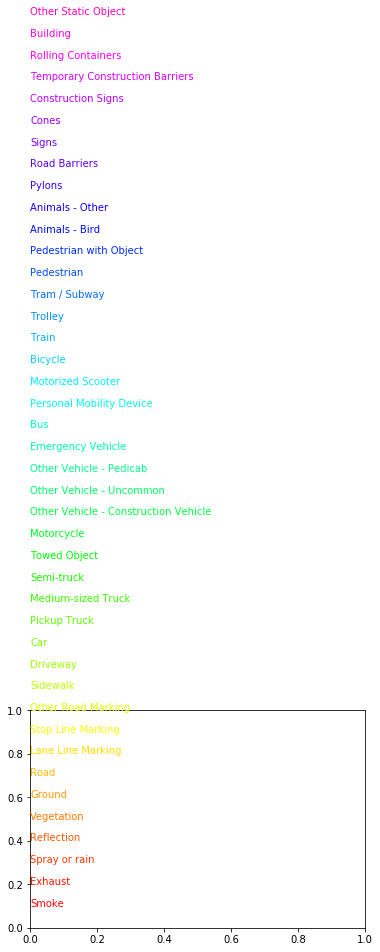

In [3]:
colormap = cm.get_cmap('gist_rainbow', 43)
#colormap = cm.get_cmap('prism', 43)
for key in seq002.semseg.classes:
    plt.text(0.0, int(key)*0.1, seq002.semseg.classes[key], color=colormap(int(key)))
plt.show()

### Define the export functions
For all data I want to publish in VR we need to write our own export function. I currently wrote export functions for a single raw lidars scan, the semantic segmentation labeled lidar scan, and the labeled bounding boxes. 

In [4]:
pc0_np = seq002.lidar[0].values
semseg0 = seq002.semseg[0]

In [5]:
def save_XYZI(points, filename):
    # Resize the pointcloud
    points[:,:3] *= RESIZE_FACTOR

    # Hue between 0 and 1
    points[:,3] /= 255.0

    # Swap dimensions: switching Y and Z and then flipping Z to get the Three JS coordinate system
    points = points[:,[0,2,1,3]]
    points[:,2] *= -1 

    # and save them! Ready to upload to immersivepoints.com
    points.astype(np.float32).byteswap().tofile(filename)

save_XYZI(pc0_np.copy(), 'scale.npy')

In [6]:
def save_XYZRGB(points, semseg, filename):
    color_values = colormap(semseg[:,0])

    # Resize the pointcloud
    points[:,:3] *= RESIZE_FACTOR

    # Hue between 0 and 1
    points[:,3] /= 255.0

    # Swap dimensions: switching Y and Z and then flipping Z to get the Three JS coordinate system
    points = points[:,[0,2,1,3]]
    points[:,2] *= -1 
    
    # Create a new numpy array with same number of points but 6 axes
    newpoints = np.zeros((points.shape[0], 6))
    newpoints[:,:3] = points[:,:3] 
    newpoints[:,3:6] = color_values[:,:3]
    newpoints.astype(np.float32).byteswap().tofile(filename)
save_XYZRGB(pc0_np.copy(), semseg0.values.copy(), 'scale_semseg.npy')

In [7]:
def save_boxes(cuboid_values, filename):
    colors_classes = defaultdict(lambda: (1.0, 0.0, 0.0))
    colors_classes['Car'] = (0.0, 1.0, 0.0)
    colors_classes['Pedestrian'] = (0.8, 0.8, 0.2)
    colors_classes['Pickup Truck'] = (0.8, 0.2, 0.8)
    colors_classes['Signs'] = (0.0, 0.0, 1.0)

    # Default color values
    cx, cy, cz = 0.0, 0.0, 0.0
    sx, sy, sz = 0.0, 0.0, 0.0
    rx, ry, rz = 0.0, 0.0, 0.0
    r, g, b, alpha = 0.0, 0.0, 0.0, 0.2

    bboxes = list()
    for cuboid in cuboid_values:
        r, g, b = colors_classes[cuboid[1]]
        
        # Note: switching Y and Z and then flipping Z to get the Three JS coordinate system
        cx = cuboid[5] * RESIZE_FACTOR
        cy = cuboid[7] * RESIZE_FACTOR
        cz = -1*cuboid[6] * RESIZE_FACTOR 
        
        # Note: also here switching Y and Z, no need to flip size though. 
        sx = cuboid[8] * RESIZE_FACTOR
        sy = cuboid[10] * RESIZE_FACTOR
        sz = cuboid[9] * RESIZE_FACTOR

        # Yaw only rotates around the Y axis
        ry = cuboid[2]  
        bboxes.append((cx, cy, cz, sx, sy, sz, rx, ry, rz, r,g,b,alpha))

    bboxes = np.array(bboxes, dtype=np.float32)
    bboxes.astype(np.float32).byteswap().tofile(filename)
    
save_boxes(seq002.cuboids[0].values, 'scale_boxes.npy')

## Export all files
Now that we have functions to export the individual data we can export a part of it to put it on immersivepoints.com. This is simply a for-loop over the data, where I save the results in a folder I put on my own S3 bucket. I also print the URL I later have to embed. 


In [ ]:
for name in dataset.sequences(with_semseg=True)[:20]:
    seq = dataset[name]
    seq.load()
    pc0_np = seq.lidar[0].values
    semseg0_np = seq.semseg[0].values
    
    save_XYZI(pc0_np.copy(), os.path.join('panda-export', name+ '_xyzi.npy'))
    save_XYZRGB(pc0_np.copy(), semseg0_np.copy(), os.path.join('panda-export', name+ '_xyzrgb.npy'))
    save_boxes(seq.cuboids[0].values, os.path.join('panda-export', name+ '_bbox.npy'))
    
    todisplay = {
        "points": [
            {
                "source": "url",
                "url": "https://pointcloudvisualization.s3.eu-central-1.amazonaws.com/panda-export/"+name+"_xyzrgb.npy",
                "type": "XYZRGB",
            }
        ],
    }
    data = json.dumps(todisplay)
    data = base64.urlsafe_b64encode(json.dumps(todisplay).encode())

    url = 'https://immersivepoints.com/oculus.html?jsonb64=' + data.decode('ascii')
    print("<a href="+url+"> Frame", name, "lidar with semantic segmentation</a><br>")
    todisplay = {
        "points": [
            {
                "source": "url",
                "url": "https://pointcloudvisualization.s3.eu-central-1.amazonaws.com/panda-export/"+name+"_xyzi.npy",
                "type": "XYZI",
            }
        ],
         "bboxes": [
             {
                "source": "url",
                "url": "https://pointcloudvisualization.s3.eu-central-1.amazonaws.com/panda-export/"+name+"_bbox.npy",
            }
        ]
    }
    
    data = json.dumps(todisplay)
    data = base64.urlsafe_b64encode(json.dumps(todisplay).encode())

    url = 'https://immersivepoints.com/oculus.html?jsonb64=' + data.decode('ascii')
    print("<a href="+url+"> Frame", name, "lidar with bounding boxes</a><br>")

<a href=https://immersivepoints.com/oculus.html?jsonb64=eyJwb2ludHMiOiBbeyJzb3VyY2UiOiAidXJsIiwgInVybCI6ICJodHRwczovL3BvaW50Y2xvdWR2aXN1YWxpemF0aW9uLnMzLmV1LWNlbnRyYWwtMS5hbWF6b25hd3MuY29tL3BhbmRhLWV4cG9ydC8wMjRfeHl6cmdiLm5weSIsICJ0eXBlIjogIlhZWlJHQiJ9XX0=> Frame 024 lidar with semantic segmentation</a><br>
<a href=https://immersivepoints.com/oculus.html?jsonb64=eyJwb2ludHMiOiBbeyJzb3VyY2UiOiAidXJsIiwgInVybCI6ICJodHRwczovL3BvaW50Y2xvdWR2aXN1YWxpemF0aW9uLnMzLmV1LWNlbnRyYWwtMS5hbWF6b25hd3MuY29tL3BhbmRhLWV4cG9ydC8wMjRfeHl6aS5ucHkiLCAidHlwZSI6ICJYWVpJIn1dLCAiYmJveGVzIjogW3sic291cmNlIjogInVybCIsICJ1cmwiOiAiaHR0cHM6Ly9wb2ludGNsb3VkdmlzdWFsaXphdGlvbi5zMy5ldS1jZW50cmFsLTEuYW1hem9uYXdzLmNvbS9wYW5kYS1leHBvcnQvMDI0X2Jib3gubnB5In1dfQ==> Frame 024 lidar with bounding boxes</a><br>
<a href=https://immersivepoints.com/oculus.html?jsonb64=eyJwb2ludHMiOiBbeyJzb3VyY2UiOiAidXJsIiwgInVybCI6ICJodHRwczovL3BvaW50Y2xvdWR2aXN1YWxpemF0aW9uLnMzLmV1LWNlbnRyYWwtMS5hbWF6b25hd3MuY29tL3BhbmRhLWV4cG9ydC8wMjNfeHl6cmdiL

### Show the result
As a nice added bonus we can also see the result in a Jupyter Notebook by putting it in an iframe. 

In [ ]:
iframe = '<iframe src=' + url + ' width=1000 height=550></iframe>'
IPython.display.HTML(iframe)